# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
import lzma
import numpy as np
import gymnasium as gym
import serde.json
import typing
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

from utils.env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from utils.model import deviceof
from utils.in_memory_scenario_env import InMemoryScenarioEnv
from utils.loader import getFiles, fullPath
from utils.waymo_loader import extract_scenarios_file
from utils.scenario_converter import extract_trajectory
from utils.idm_model_def import InverseDynamicsModel
from utils.scenario import Scenario


from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"
DEST_DATA_PATH = "~/data/waymo_scenarios"

2023-09-17 17:06:48.301800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 17:06:49.501720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
for scenarios_in_file in map(extract_scenarios_file, getFiles(WAYMO_DATA_PATH)):
    print(f"Loaded {len(scenarios_in_file)} scenarios.")
    for scenario in scenarios_in_file:
        with open(fullPath(f"{DEST_DATA_PATH}/{scenario.scenario_id}.json"), "w") as f:
            f.write(serde.json.to_json(scenario))

2023-09-17 09:46:58.609997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 09:46:58.629212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 09:46:58.629479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loaded 61 scenarios.
Loaded 72 scenarios.
Loaded 64 scenarios.
Loaded 65 scenarios.
Loaded 65 scenarios.
Loaded 84 scenarios.
Loaded 68 scenarios.
Loaded 65 scenarios.
Loaded 57 scenarios.
Loaded 58 scenarios.
Loaded 72 scenarios.
Loaded 60 scenarios.
Loaded 71 scenarios.
Loaded 66 scenarios.
Loaded 67 scenarios.
Loaded 68 scenarios.
Loaded 90 scenarios.
Loaded 55 scenarios.
Loaded 71 scenarios.
Loaded 75 scenarios.
Loaded 67 scenarios.
Loaded 67 scenarios.
Loaded 75 scenarios.
Loaded 77 scenarios.
Loaded 67 scenarios.
Loaded 68 scenarios.
Loaded 63 scenarios.
Loaded 87 scenarios.
Loaded 73 scenarios.
Loaded 64 scenarios.
Loaded 64 scenarios.
Loaded 57 scenarios.
Loaded 75 scenarios.
Loaded 76 scenarios.
Loaded 75 scenarios.
Loaded 72 scenarios.
Loaded 68 scenarios.
Loaded 61 scenarios.
Loaded 66 scenarios.
Loaded 68 scenarios.
Loaded 88 scenarios.
Loaded 68 scenarios.
Loaded 81 scenarios.
Loaded 72 scenarios.
Loaded 70 scenarios.
Loaded 64 scenarios.
Loaded 69 scenarios.
Loaded 65 sce

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idm = InverseDynamicsModel().to(device)
idm.load_state_dict(torch.load('./data/idm.pth'))    

<All keys matched successfully>

Let's try visualizing our IDM by having it follow a track from start to finish.

In [3]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return Action(steering.item(), throttle.item())


### Trajectory Replay

In [25]:
env = InMemoryScenarioEnv(config={"use_render": True, "manual_control": False})

In [26]:
scenario_index = 5

with open(getFiles(DEST_DATA_PATH)[scenario_index], "r") as f:
    scenario = serde.json.from_json(Scenario, f.read())
    trajectory = extract_trajectory(scenario.tracks[scenario.ego_track_index])
# reset
env.set_scenario(scenario)

In [9]:
env.reset()
# set the initial state
for i in range(len(trajectory)):
    st = trajectory[i]
    env.vehicle.set_position(scenario.tracks[scenario.ego_track_index].states[i].position)
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
show_dest_mark and show_line_to_dest are not supported in TrajectoryNavigation


### Closed Loop IDM

In [28]:
idm.eval()

# reset
env.reset()

st = trajectory[0]

# set the initial state
env.vehicle.set_velocity(st.velocity)
env.vehicle.set_heading_theta(st.heading)


for i in range(len(trajectory)-1):
    # st0 = scenario.tracks[scenario.ego_track_index].states[i]
    # st1 =  scenario.tracks[scenario.ego_track_index].states[i]
    st0 = trajectory[i]
    st1 = trajectory[i+1]
    st0_pred = get_metadrive_state(env)
    action = IDMPolicy(idm)(Observation(st0_pred, st1))
    env.step(np.array([action.steer, action.throttle]))
    st1_pred = get_metadrive_state(env)
    print(action)
    print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
    

783
{'258': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7fdc2faaba90>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '316': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7fdbe851d790>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '321': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7fdbe85e3650>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '322': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7fdbe85e3ed0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '323': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7fdbe85e37d0>, entry_lanes=None, exit_lanes=None, left_lanes=None, right_lanes=None), '324': neighbor_lanes(lane=<metadrive.component.lane.scenario_lane.ScenarioLane object at 0x7fdbe9b13650>

### Open Loop IDM

In [11]:
with torch.no_grad():
    # reset
    env.reset()
    st = trajectory[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(trajectory)-1):
        st0 = trajectory[i]
        st1 = trajectory[i+1]
        action = IDMPolicy(idm)(Observation(st0, st1))
        env.step(np.array([action.steer, action.throttle]))
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

Action(steer=-0.007938340306282043, throttle=-0.00837203860282898)
[-12.02766132   0.72545564] 3.084751874337851 (-12.0187025, 0.73754925) 3.08393574396451
Action(steer=-0.008436707779765129, throttle=-0.016240566968917847)
[-12.00065994   0.73288608] 3.0836965967559067 (-11.995725, 0.75621164) 3.0823742962336187
Action(steer=-0.009527089074254036, throttle=-0.022578582167625427)
[-11.96196461   0.76203912] 3.0812036116594834 (-11.961978, 0.7818904) 3.080191254931174
Action(steer=-0.010380284860730171, throttle=-0.028029531240463257)
[-11.91363811   0.80093473] 3.078124464807134 (-11.918781, 0.81238705) 3.077536476568868
Action(steer=-0.01089324988424778, throttle=-0.03225964307785034)
[-11.85829258   0.83959723] 3.0747402528519157 (-11.8681, 0.84551036) 3.07456027175055
Action(steer=-0.011866593733429909, throttle=-0.03525969386100769)
[-11.79762459   0.88163024] 3.0711416564289458 (-11.812156, 0.8793796) 3.0713964762533266
Action(steer=-0.012724662199616432, throttle=-0.0373721569776

In [29]:
env.close()

In [33]:
import tqdm

In [40]:
def load_file(filename: str) -> list[State]:
    with open(filename, "r") as f:
        scenario = serde.json.from_json(Scenario, f.read())
        return extract_trajectory(scenario.tracks[scenario.ego_track_index])


trajectories: list[list[State]] = []
with ProcessPoolExecutor() as executor:
    for trajectory in tqdm.tqdm(executor.map(load_file, getFiles(DEST_DATA_PATH))):
        trajectories.append(trajectory)

1666it [01:02, 26.85it/s]


KeyboardInterrupt: 

In [41]:
observations: list[Observation] = []
for t in trajectories:
    for i in range(len(t)-1):
        observations.append(Observation(t[i], t[i+1]))

import random
random.seed(42)
observations_test_set = random.sample(observations, 500)

In [30]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [31]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(np.array(s_pred.velocity) - np.array(s_true.velocity)) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0 = o.state
    s1 = o.next_state
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

[INFO] Assets version: 0.4.1.2
:device(warning): /dev/input/event20 is not readable, some features will be unavailable.
:device(warning): /dev/input/event21 is not readable, some features will be unavailable.
:device(warning): /dev/input/event22 is not readable, some features will be unavailable.


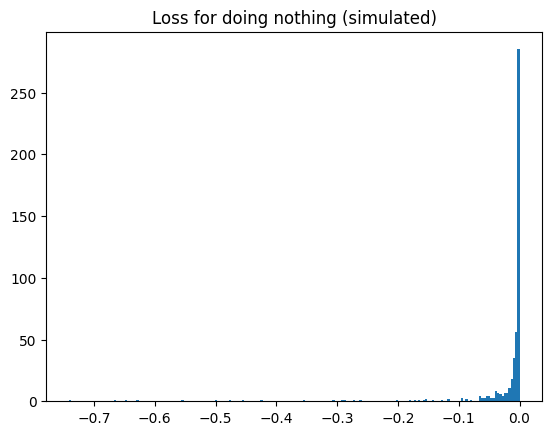

mean -0.025508836099201765
median -0.002425057241775617


In [23]:
def null_policy(_:Observation) -> Action:
    return Action(0, 0)

# test loss function
do_nothing_loss = []
for obs in observations_test_set:
    _, rew, _ = run_game(env, null_policy, obs)
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

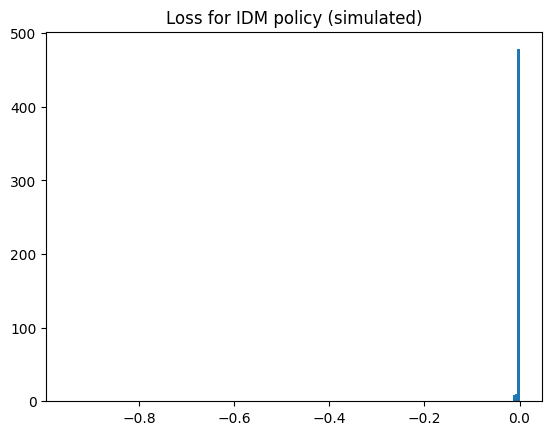

mean -0.002584204635922992
median -4.0740916070510904e-05


In [47]:
# test loss function
idm_loss = []
for o in observations_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), o)
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

In [45]:
obs_tensor = obs_batch_to_tensor(observations, deviceof(idm))
idm.eval()
action_pred = idm(obs_tensor)

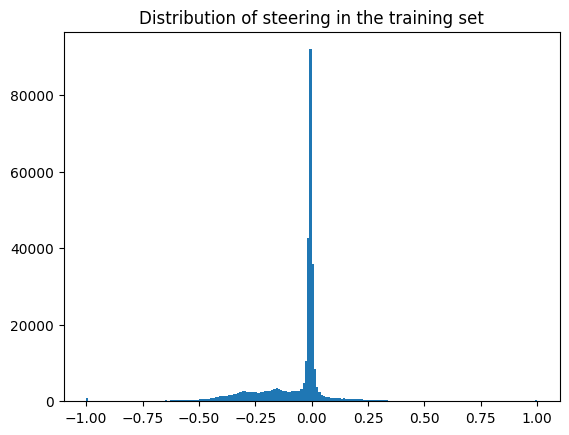

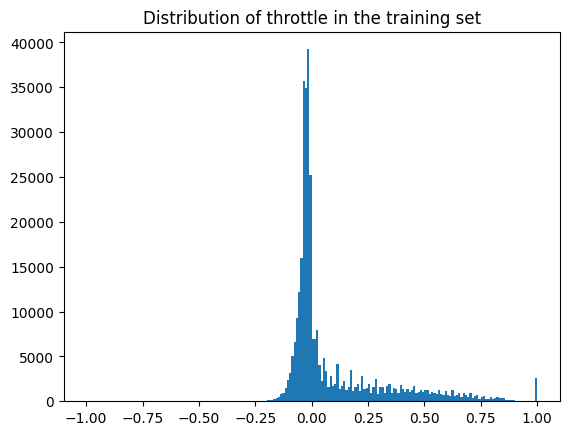

In [46]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()